### **Fontes de pesquisa:**
> **Artigos** 
- 4 Strategies for Multi-Step Time Series Forecasting: https://machinelearningmastery.com/multi-step-time-series-forecasting/
- How to Convert a Time Series to a Supervised Learning Problem in Python: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
- Time Series Forecasting as Supervised Learning: https://machinelearningmastery.com/time-series-forecasting-supervised-learning/
- How to Use XGBoost for Time Series Forecasting: https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

> **Documentação**
- Métricas de Avaliação: https://scikit-learn.org/stable/modules/model_evaluation.html

In [1]:
# Data processing
import pandas as pd
import numpy as np
import seaborn as sns

# Standardize the data (padronização)
from sklearn.preprocessing import StandardScaler

# Modeling 
from sklearn.svm import SVR

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from matplotlib import pyplot as plt


import warnings
warnings.filterwarnings("ignore")
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
# df = pd.read_csv('https://raw.githubusercontent.com/luk3mn/TCC-predicao-de-series-temporais/master/dataset/dataset_macau.csv')
df = pd.read_csv('C:\projetos\jupyter_notebook\hyperparams_optimization\_data\dataset_macau.csv')
# Removendo todos as virgulas do dataset
df.replace(',','.', regex=True, inplace=True)

# Convertendo a coluna "Data" em datetime
df.Data = pd.to_datetime(df.Data)

# Tranformando a coluna "Data" em index
df.set_index('Data', inplace=True)

# Convertendo todos os objetos para valores numericos
c = df.select_dtypes(object).columns
df[c] = df[c].apply(pd.to_numeric,errors='coerce')
df.head()

,Velocidade,Temperatura,Umidade,Pressão,Direção
Data,,,,,
2004-01-01,6.33,29.13,67.67,1010.97,11.00
2004-01-02,4.63,29.47,70.33,1010.67,5.67
2004-01-03,5.47,29.00,73.00,1010.20,7.67
2004-01-04,7.97,30.00,70.00,1009.57,10.67
2004-01-05,6.73,29.60,67.67,1009.03,11.00


In [3]:
df = df.drop(columns=['Temperatura','Umidade','Pressão','Direção'])
df

,Velocidade
Data,
2004-01-01,6.33
2004-01-02,4.63
2004-01-03,5.47
2004-01-04,7.97
2004-01-05,6.73
...,...
2017-05-27,3.76
2017-05-28,8.64
2017-05-29,8.88


<AxesSubplot: xlabel='Data'>

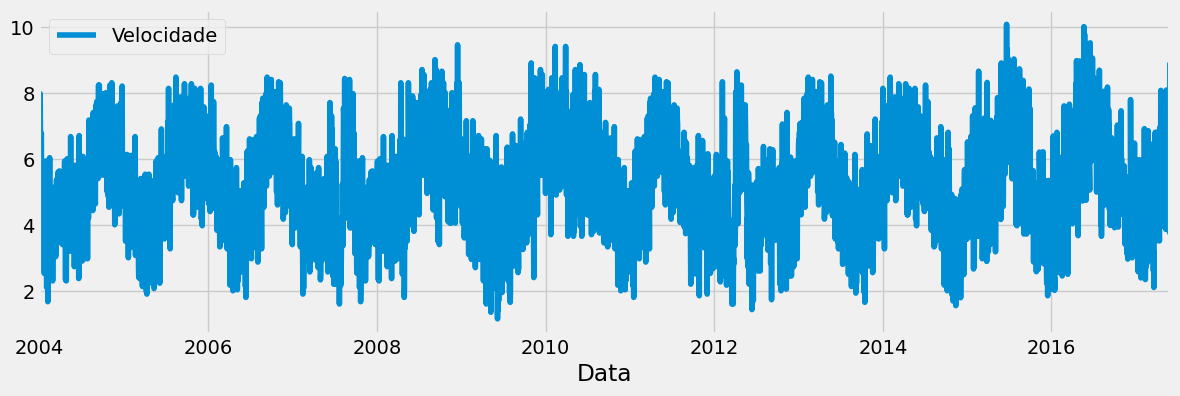

In [4]:
df.plot(figsize=(13,4))

## Pré-processamento
> Separação dos dados em treino / teste

In [5]:
def split_dataset(data, set_size, show_series):
    x = data
    size = int(len(x) * set_size)
    train, test = x[0:size], x[size:len(x)]
    if show_series:
        print("\nBASE DE TREINO\n",train.tail())
        print("\nBASE DE TESTE\n",test.head())
    else:
        print("BASE DE TREINO: ",len(train))
        print("BASE DE TESTE:  ",len(test))
    return train, test

In [6]:
train_set, test_set = split_dataset(df, 0.75, True)


BASE DE TREINO
             Velocidade
Data                  
2014-01-18        4.87
2014-01-19        4.73
2014-01-20        6.87
2014-01-21        6.10
2014-01-22        7.40

BASE DE TESTE
             Velocidade
Data                  
2014-01-23        7.10
2014-01-24        7.10
2014-01-25        7.63
2014-01-26        5.53
2014-01-27        6.70


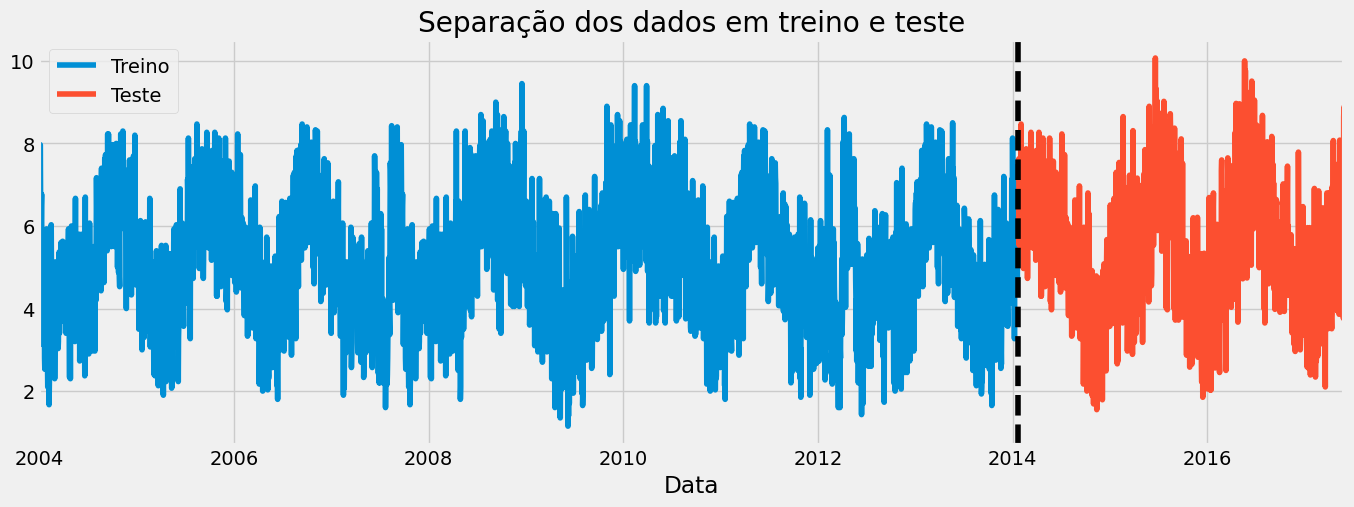

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))
train_set.plot(ax=ax, label='Treino', title='Separação dos dados em treino e teste')
test_set.plot(ax=ax, label='Teste')
ax.axvline('2014-01-22', color='black', ls='--')
ax.legend(['Treino', 'Teste'])
plt.show()

> Feature Engineering

In [8]:
# from pandas import DataFrame
# from pandas import concat

# def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
# 	"""
# 	Frame a time series as a supervised learning dataset.
# 	Arguments:
# 		data: Sequence of observations as a list or NumPy array.
# 		n_in: Number of lag observations as input (X).
# 		n_out: Number of observations as output (y).
# 		dropnan: Boolean whether or not to drop rows with NaN values.
# 	Returns:
# 		Pandas DataFrame of series framed for supervised learning.
# 	"""
# 	n_vars = 1 if type(data) is list else data.shape[1]
# 	df = DataFrame(data)
# 	cols, names = list(), list()
# 	# input sequence (t-n, ... t-1)
# 	for i in range(n_in, 0, -1):
# 		cols.append(df.shift(i))
# 		names += [('X%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# 	# forecast sequence (t, t+1, ... t+n)
# 	for i in range(0, n_out):
# 		cols.append(df.shift(-i))
# 		if i == 0:
# 			names += [('y%d(t)' % (j+1)) for j in range(n_vars)]
# 		else:
# 			names += [('y%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# 	# put it all together
# 	agg = concat(cols, axis=1)
# 	agg.columns = names
# 	# drop rows with NaN values
# 	if dropnan:
# 		agg.dropna(inplace=True)
# 	return agg

# tam_janela = 1
# passos = 2
# train_data_features = series_to_supervised(train_set, n_in=tam_janela, n_out=passos)
# test_data_features = series_to_supervised(test_set, n_in=tam_janela, n_out=passos)

- shift(1)  -> Empurra os dados para frente (Cria a variável de entrada [X], nesse caso, as lag features, aquelas de usamos para prever)
- shift(-1) -> Puxa os dados para trás (Cria a variável de saída [y], nesse caso a variável target, aquela que queremos prever)

In [8]:
def series_to_supervised_lag(serie, steps_in):
    features = pd.DataFrame() # dataframe para retorno
    features['t'] = serie # valores em t
    for i in range(1, steps_in+1): # valores em t-1, t-2, .. t-steps_in
        features['t-'+str(i)] = serie.shift(i)
    features = features.iloc[steps_in:] # remove linhas iniciais com nan
    return features

def series_to_supervised(serie, steps_in):
    features = pd.DataFrame() # dataframe para retorno
    features['t'] = serie # valores em t
    for i in range(1, steps_in+1): # valores em t-1, t-2, .. t-steps_in
        features['target+'+str(i)] = serie.shift(-i)
    features = features.dropna() # remove linhas iniciais com nan
    return features

- Criando as features para prever 3 passos a frente

In [22]:
lag = 3
series_to_supervised_lag(serie=train_set, steps_in=lag).tail(6)

,t,t-1,t-2,t-3
Data,,,,
2014-01-17,5.87,6.40,7.43,7.33
2014-01-18,4.87,5.87,6.40,7.43
2014-01-19,4.73,4.87,5.87,6.40
2014-01-20,6.87,4.73,4.87,5.87
2014-01-21,6.10,6.87,4.73,4.87
2014-01-22,7.40,6.10,6.87,4.73


In [9]:
passos = 3
train_data_features = series_to_supervised(serie=train_set, steps_in=passos)
test_data_features = series_to_supervised(serie=test_set, steps_in=passos)

print(train_data_features.tail(3))
print(test_data_features.head(3))

               t  target+1  target+2  target+3
Data                                          
2014-01-17  5.87      4.87      4.73      6.87
2014-01-18  4.87      4.73      6.87      6.10
2014-01-19  4.73      6.87      6.10      7.40
               t  target+1  target+2  target+3
Data                                          
2014-01-23  7.10      7.10      7.63      5.53
2014-01-24  7.10      7.63      5.53      6.70
2014-01-25  7.63      5.53      6.70      7.47


In [10]:
X_train = train_data_features.drop(columns=['target+'+str(passos)]).values
y_train = train_data_features.iloc[:,[passos]].values
X_test = test_data_features.drop(columns=['target+'+str(passos)]).values
y_test = test_data_features.iloc[:,[passos]].values

In [11]:
print('X Test: ', X_test[0])
print('y Test: ', y_test[0])

X Test:  [7.1  7.1  7.63]
y Test:  [5.53]


In [12]:
svr = SVR(C=6.95, epsilon=0.048) # 0.7412 (arredondado)
svr.fit(X_train, y_train)

# Verifica a acurácia
# print(f'O ponto de acurácia do modelo é {svr.score(X_test, y_test):.4f}')

SVR(C=6.95, epsilon=0.048)

In [32]:
i = 0
print("ITERAÇÃO ", i)
print("X Teste: ", X_test.reshape(1, -1))
print("y Teste: ", y_test.reshape(1, -1))

print("\nX Predicao: ", X_test[i])
_1passos = svr.predict([X_test[i]])
print("y Real: ", y_test[i])
print("Predito: ", _1passos)

ITERAÇÃO  0
X Teste:  [[7.1  7.1  7.63 ... 8.64 8.88 7.  ]]
y Teste:  [[5.53 6.7  7.47 ... 8.88 7.   5.72]]

X Predicao:  [7.1  7.1  7.63]
y Real:  [5.53]
Predito:  [7.01184329]


## Previsão em Etapas de Tempo

> Otimização por busca bayesiana

In [41]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit

# Set up the k-fold cross-validation
# kfold = KFold(n_splits=3, shuffle=True, random_state=0)
ts_cv = TimeSeriesSplit(n_splits=5)

# log-uniform: understand as search over p = exp(x) by varying x
opt = BayesSearchCV(
    SVR(),
    {
        'C': Real(1e-1, 10.0, prior='log-uniform'),
        # 'gamma': Real(1e-1, 1.0, prior='log-uniform'),
        # 'degree': Integer(1, 5),
        'epsilon': Real(1e-4, 1.0),
        # 'kernel': Categorical(['linear', 'poly', 'rbf']),
    },
    n_iter=32,
    # cv=kfold,
    cv=ts_cv,
    scoring='neg_mean_squared_error',
    random_state=0
)

In [51]:
def fit_predict_steps(passos=1, otimizacao=False, C=10.0, epsilon=0.0001):
    predicted = []
    yTrue = []
    mae_error = []
    mse_error = []

    for i in range(1, passos+1):
        train_data_features = series_to_supervised(serie=train_set, steps_in=i)
        test_data_features = series_to_supervised(serie=test_set, steps_in=i)

        X_train = train_data_features.drop(columns=['target+'+str(i)]).values
        y_train = train_data_features.iloc[:,[i]].values
        X_test = test_data_features.drop(columns=['target+'+str(i)]).values
        y_test = test_data_features.iloc[:,[i]].values

        # treina o modelo
        if otimizacao:
            opt.fit(X_train, y_train)
            C, epsilon = [opt.best_estimator_.C, opt.best_estimator_.epsilon]
        svr = SVR(C=C, epsilon=epsilon)
        svr.fit(X_train, y_train)

        pred = svr.predict([X_test[0]])
        true = y_test[0]
        mae = mean_absolute_error(pred, true)
        mse = mean_squared_error(pred, true)

        print('[{}] Real: {} || Predito: {} || MAE: {} => SVR(C={}, epsilon={})'.format(i, true, pred, mae, C, epsilon))

        predicted.append(pred)
        yTrue.append(true)
        mae_error.append(mae)
        mse_error.append(mse)

    return predicted, yTrue, mae_error, mse_error

In [105]:
def plot_result(predictions, y_true, mae=0, mse=0, rmse=0, title='', xlabel=''):
    fig = plt.subplots(figsize=(8,4))
    plt.plot(y_true, label='Validação')
    plt.plot(predictions, label='Previsto')
    if (mae != 0) | (mse != 0) | (rmse != 0):
        plt.title(f'{title}\nMSE: {mse:.3f} || RMSE: {rmse:.3f} || MAE: {mae:.3f}')
    else:
        plt.title(f'{title}')
    plt.xlabel('Periodo Observado')
    plt.ylabel(xlabel)
    plt.legend()
    plt.tight_layout()

In [54]:
predicao, real, mae, mse = fit_predict_steps(passos=12, otimizacao=True)

[1] Real: [7.1] || Predito: [6.40944764] || MAE: 0.6905523568584009 => SVR(C=0.606668392882532, epsilon=1.0)
[2] Real: [7.63] || Predito: [6.55622566] || MAE: 1.0737743359691345 => SVR(C=0.9264283027965066, epsilon=0.7565443962154562)
[3] Real: [5.53] || Predito: [6.82185774] || MAE: 1.2918577390900783 => SVR(C=1.8488035327824814, epsilon=0.9993395912566331)
[4] Real: [6.7] || Predito: [6.56884778] || MAE: 0.1311522183558873 => SVR(C=0.5483703374321858, epsilon=0.4402396153755277)
[5] Real: [7.47] || Predito: [6.76721698] || MAE: 0.7027830214197994 => SVR(C=0.9547068295000105, epsilon=0.7027388615447301)
[6] Real: [6.27] || Predito: [6.26001484] || MAE: 0.009985158027705054 => SVR(C=0.8478899502709536, epsilon=0.8287318880755755)
[7] Real: [7.] || Predito: [6.44999007] || MAE: 0.5500099300199013 => SVR(C=1.3594925731427987, epsilon=0.4981120751951506)
[8] Real: [5.5] || Predito: [6.76857507] || MAE: 1.2685750724378657 => SVR(C=0.8079227877131577, epsilon=0.2557419225303705)
[9] Real: [

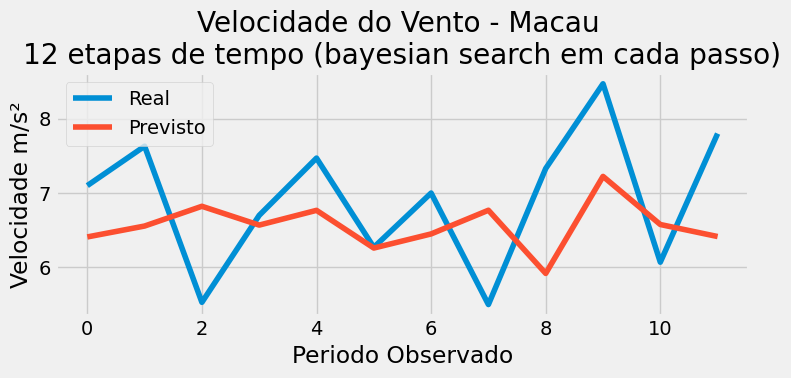

In [116]:
plot_result(predictions=predicao, y_true=real, title='Velocidade do Vento - Macau \n12 etapas de tempo (bayesian search em cada passo)', xlabel='Velocidade m/s²')

In [56]:
pred, true, error_mae, error_mse = fit_predict_steps(passos=12, otimizacao=False)

[1] Real: [7.1] || Predito: [6.5609111] || MAE: 0.5390888965356586 => SVR(C=10.0, epsilon=0.0001)
[2] Real: [7.63] || Predito: [6.64848185] || MAE: 0.9815181488931151 => SVR(C=10.0, epsilon=0.0001)
[3] Real: [5.53] || Predito: [7.05316726] || MAE: 1.5231672594685604 => SVR(C=10.0, epsilon=0.0001)
[4] Real: [6.7] || Predito: [6.25700734] || MAE: 0.4429926623686846 => SVR(C=10.0, epsilon=0.0001)
[5] Real: [7.47] || Predito: [6.77710629] || MAE: 0.6928937099202921 => SVR(C=10.0, epsilon=0.0001)
[6] Real: [6.27] || Predito: [6.21868061] || MAE: 0.05131939392536822 => SVR(C=10.0, epsilon=0.0001)
[7] Real: [7.] || Predito: [6.63319461] || MAE: 0.366805387029034 => SVR(C=10.0, epsilon=0.0001)
[8] Real: [5.5] || Predito: [6.4265556] || MAE: 0.9265555980891449 => SVR(C=10.0, epsilon=0.0001)
[9] Real: [7.33] || Predito: [5.90660776] || MAE: 1.423392240609103 => SVR(C=10.0, epsilon=0.0001)
[10] Real: [8.47] || Predito: [7.03075319] || MAE: 1.4392468141538979 => SVR(C=10.0, epsilon=0.0001)
[11] Re

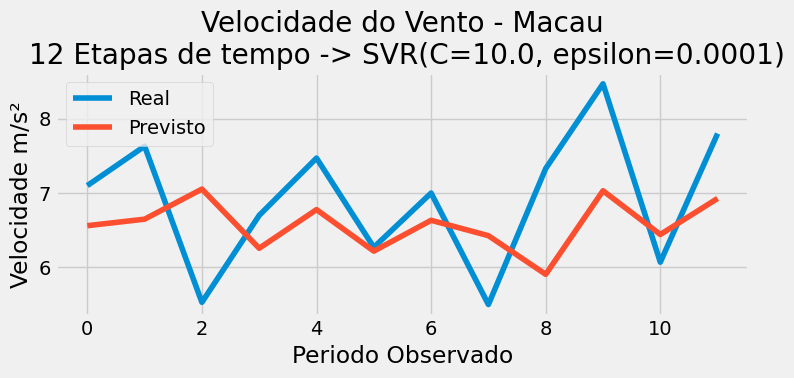

In [118]:
plot_result(predictions=pred, y_true=true, title='Velocidade do Vento - Macau\n 12 Etapas de tempo -> SVR(C=10.0, epsilon=0.0001)', xlabel='Velocidade m/s²')

> comparando os resultados

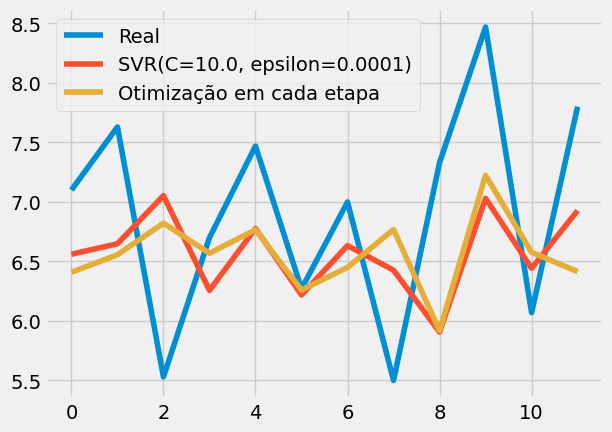

In [123]:
plt.plot(true, label='Validação')
plt.plot(pred, label='SVR(C=10.0, epsilon=0.0001)')
plt.plot(predicao, label='Otimização em cada etapa')
plt.legend()

In [156]:
passos = []
for i in range(1,13):
    passos.append(i)

dataset_result = pd.DataFrame()
dataset_result['Passos'] = passos
dataset_result['Real'] = true
dataset_result['SVR(C=10.0, epsilon=0.0001)'] = pred
dataset_result['MSE 1'] = error_mse
dataset_result['MAE 1'] = error_mae
dataset_result['BayeSearch por etapa'] = predicao
dataset_result['MSE 2'] = mse
dataset_result['MAE 2'] = mae
dataset_result

,Passos,Real,"SVR(C=10.0, epsilon=0.0001)",MSE 1,MAE 1,BayeSearch por etapa,MSE 2,MAE 2
0,1,[7.1],[6.560911103464341],0.290617,0.539089,[6.409447643141599],0.476863,0.690552
1,2,[7.63],[6.648481851106885],0.963378,0.981518,[6.556225664030865],1.152991,1.073774
2,3,[5.53],[7.053167259468561],2.320039,1.523167,[6.8218577390900785],1.668896,1.291858
3,4,[6.7],[6.257007337631316],0.196242,0.442993,[6.568847781644113],0.017201,0.131152
4,5,[7.47],[6.777106290079708],0.480102,0.692894,[6.7672169785802],0.493904,0.702783
5,6,[6.27],[6.218680606074631],0.002634,0.051319,[6.2600148419722945],0.000100,0.009985
6,7,[7.0],[6.633194612970966],0.134546,0.366805,[6.449990069980099],0.302511,0.550010
7,8,[5.5],[6.426555598089145],0.858505,0.926556,[6.768575072437866],1.609283,1.268575
8,9,[7.33],[5.906607759390897],2.026045,1.423392,[5.91885602405942],1.991327,1.411144
9,10,[8.47],[7.030753185846103],2.071431,1.439247,[7.223959029026299],1.552618,1.246041


## Previsão Direta

> Separação Treino e Teste

In [14]:
train, test = split_dataset(df, 0.90, True)


BASE DE TREINO
             Velocidade
Data                  
2016-01-23        3.99
2016-01-24        6.39
2016-01-25        6.80
2016-01-26        2.83
2016-01-27        3.17

BASE DE TESTE
             Velocidade
Data                  
2016-01-28        5.49
2016-01-29        4.64
2016-01-30        3.39
2016-01-31        2.56
2016-02-01        4.26


> Feature Engineering

In [15]:
steps_in = 88
train_data_features = series_to_supervised_lag(train, steps_in)
test_data_features = series_to_supervised_lag(test, steps_in)

In [16]:
X_train = train_data_features.drop(columns=['t']).values
y_train = train_data_features['t'].values
X_test = test_data_features.drop(columns=['t']).values
y_test = test_data_features['t'].values

> Busca Bayesiana

In [42]:
# treina o modelo
opt.fit(X_train, y_train)
C, epsilon, kernel, gamma = [opt.best_estimator_.C, 
                             opt.best_estimator_.epsilon, 
                             opt.best_estimator_.kernel,
                             opt.best_estimator_.gamma]
print(opt.best_estimator_)
print(opt.best_params_)
print(opt.best_score_)

SVR(C=5.20192906001801, epsilon=0.06085331113386756)
OrderedDict([('C', 5.20192906001801), ('epsilon', 0.06085331113386756)])
-0.8835610847157401


In [43]:
svr = SVR(kernel=kernel, C=C, epsilon=epsilon, gamma=gamma) # 0.7412 (arredondado)
# svr = SVR(C=10.0, epsilon=0.01)
# svr = SVR(C=5.2713416686699786, epsilon=0.0001) # 0.8162891064246371
# svr = SVR(C=6.95, epsilon=0.048)
# svr = SVR(C=10.0, epsilon=0.0001)
# svr = SVR(C=5.355142606230749, epsilon=1e-08) # 0.7632851789996633
svr.fit(X_train, y_train)
print(svr.score(X_test, y_test))

0.7590337900940436


> Previsão com lag Feature

In [45]:
def predict_svr(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale', lag=1):

    # Criação dos Lags
    steps_in = lag
    train_data_features = series_to_supervised_lag(train, steps_in)
    test_data_features = series_to_supervised_lag(test, steps_in)

    # Definição de X e y
    X_train = train_data_features.drop(columns=['t']).values
    y_train = train_data_features['t'].values.reshape(-1, 1)
    X_test = test_data_features.drop(columns=['t']).values
    y_test = test_data_features['t'].values.reshape(-1, 1)

    # treina o modelo
    svr = SVR(kernel=kernel, C=C, epsilon=epsilon, gamma=gamma)
    svr.fit(X_train, y_train)
    predictions = svr.predict(X_test)
        
    # calculo do erro
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mse = mean_squared_error(y_test, predictions)

    fig = plt.subplots(figsize=(8,4))
    plt.plot(y_test[:100], label='Validação')
    plt.plot(predictions[:100], label='Previsto')
    plt.title('Velocidade do Vento (Macau) - {} lags\nMSE: {:.3f} || RMSE: {:.3f} || MAE: {:.3f}'.format(steps_in, mse, rmse, mae))
    plt.xlabel('Periodo Observado')
    plt.ylabel('Velocidade m/s²')
    plt.legend()
    plt.tight_layout()

    return predictions, y_test

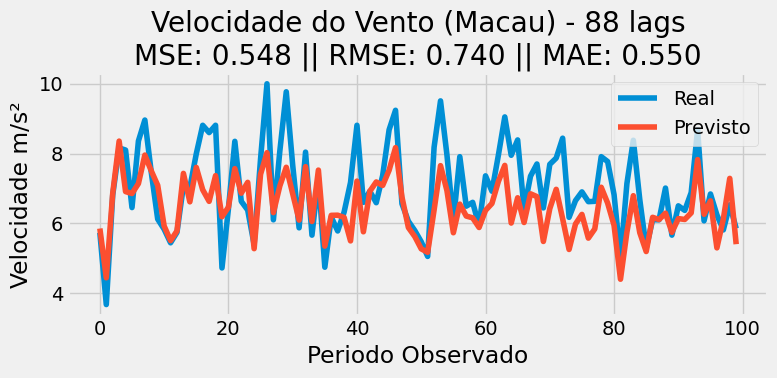

In [94]:
pred, ytrue = predict_svr(C=C, epsilon=epsilon, lag=88)

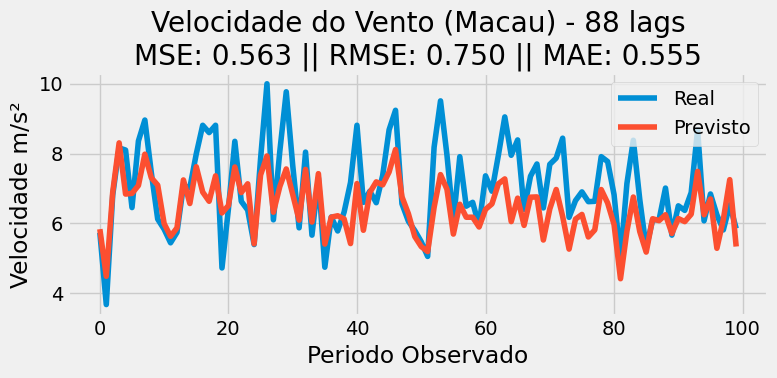

In [95]:
pred, ytrue = predict_svr(C=5.2713416686699786, epsilon=0.0001, lag=88)

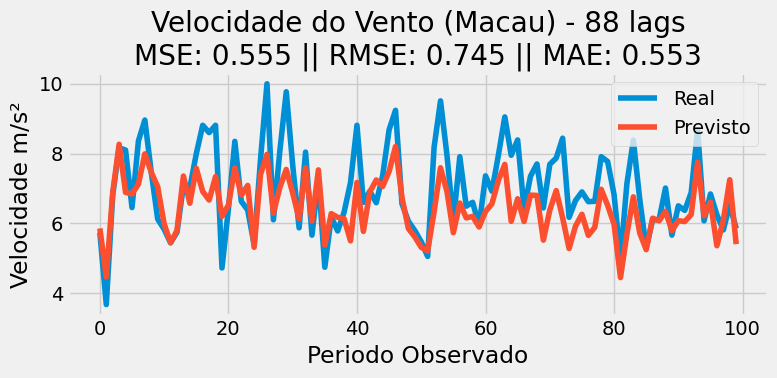

In [96]:
pred, ytrue = predict_svr(C=6.95, epsilon=0.048, lag=88)

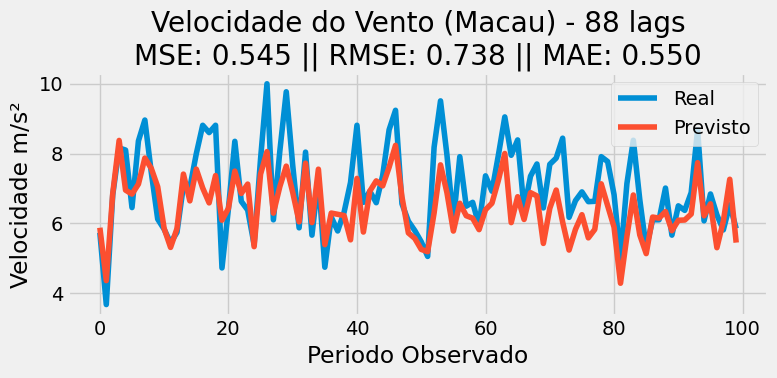

In [46]:
pred, ytrue = predict_svr(C=10.0, epsilon=0.0001, lag=88)

## Analisando os resultados

In [100]:
# svr = SVR(C=6.95, epsilon=0.048) # 0.7412 (arredondado)
# svr = SVR(C=5.2713416686699786, epsilon=0.0001)
svr = SVR(C=C, epsilon=epsilon)

# treinando o modelo
svr.fit(X_train, y_train)

# Verifica a acurácia
score = svr.score(X_test, y_test)
print(f'O ponto de acurácia do modelo é {score:.4f}')

O ponto de acurácia do modelo é 0.7689


In [105]:
# calculo do erro
mae = mean_absolute_error(ytrue, pred)
rmse = np.sqrt(mean_squared_error(ytrue, pred))
mse = mean_squared_error(ytrue, pred)

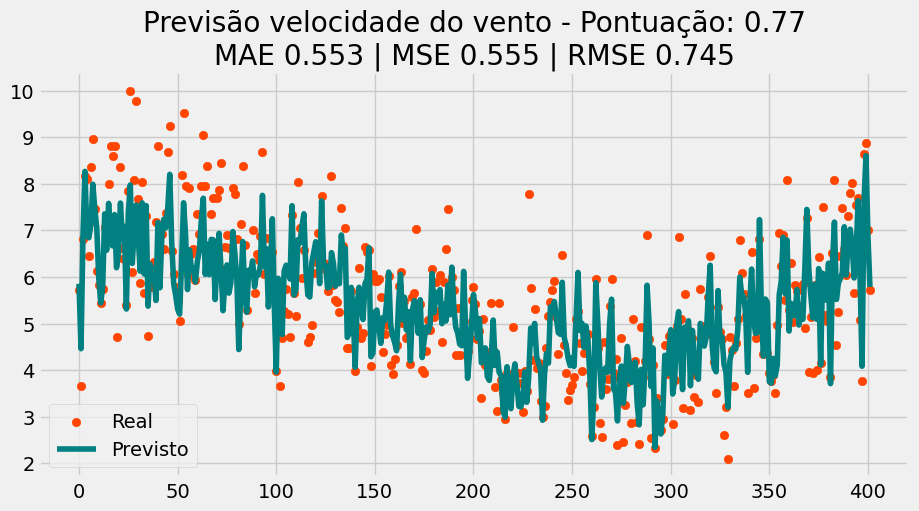

In [109]:
index = []
for i in range(len(ytrue)):
    index.append(i)

fig = plt.subplots(figsize=(10, 5))
plt.scatter(index, ytrue, label='Validação', color='orangered')
plt.plot(pred, label='Previsto', color='teal')
plt.title(f'Previsão velocidade do vento - Pontuação: {score:.2f}\nMAE {mae:.3f} | MSE {mse:.3f} | RMSE {rmse:.3f}')
plt.legend()